<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Data
By Amira (DSI-28)

---
# Problem Statement

   We are a team of data scientists working for a real estate agency in Ames, Iowa. 

   We have been tasked to identify features that are the best predictors of housings prices in the city and create a model that will produce predictions with the best metrics (R2 score and RMSE score). 

   The model will benefit our real agents, by providing a real gauge of housing prices based on key features, which can they draw reference from when they are advising clients looking at buying/selling their homes.  

   Some of the questions that a property agent might have include:
1. At what price should I advise my client to sell or buy a particular house? 
2. What features of the house are more important in determining house price?
3. Are there any features that my client can improve or remodel to fetch a higher price, if they intend to sell? 

---
# Structure

To organise my work better, I have organised this project into two notebooks: 

- Notebook 1 : Exploratory Data Analysis & Data Cleaning
- Notebook 2: Data Preprocessing & Modelling

<span style='color:red'>**This is Notebook 2.**</span>

---
## Part 2: Data Preprocessing & Modelling

In [1]:
# import required libraries/packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

sns.set(font_scale=1.3)
sns.set_style("ticks")

In [2]:
train = pd.read_csv('./datasets/train_cleaned.csv')
test = pd.read_csv('./datasets/test_cleaned.csv')

In [3]:
print(train.shape)
print(test.shape)

(2048, 24)
(878, 23)


In [4]:
# drop redundant columns 

train.drop('Unnamed: 0',axis=1,inplace=True)
test.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
# convert columns containing numeric/categorical data into strings again
# somehow this got converted back to int when we exported notebook 1. 

train['ms_subclass'] = train['ms_subclass'].astype(str)
test['ms_subclass'] = test['ms_subclass'].astype(str)

### Model Prep: One-Hot Encoding

Based on the cleaned datasets, we still have categorical data that must be manipulated into dummy or indicator variables.

In [6]:
# one hot encoding

train = pd.get_dummies(train,drop_first=True)

In [7]:
train.shape

(2048, 100)

### Model Prep: Create our features matrix (X) and target vector (y)

Since we have performed done one-hot encoding, all features have been manipulated into numeric variables 

Every numerical column (that is not our target) will be used as a feature.

Our target is *saleprice*.

In [8]:
X = train.loc[:, train.columns != 'saleprice']
y = train['saleprice']

In [9]:
num_features = [col for col in train._get_numeric_data().columns if col != 'saleprice']
all_features = [x for x in train.columns if x != 'saleprice']

### Model Prep: Train/test split

We want to have a holdout set to test our model. Therefore, we have applied the train_test_split function to split our X and y variables into a training set and a validation set.


In [10]:
# apply train-test-split to perform cross validation using hold-out-method

X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=0.7,random_state=42)

print(X_train.shape)
print(y_train.shape)

(1433, 99)
(1433,)


### Model Prep: Scaling

Our data consists of features of varying magnitudes or values or units e.g. area in square feet, sale price in US$, age of house, etc. 

Therefore, we will have to scale the features to standardize the indepenent features present in the data, in a fized range. 

In [11]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)

### Optimizing alpha values for lasso regression and ridge regression

Regularization penalizes model complexity. If the alpha is high, it will decrease the error due to variance and will result in overfit. On the flip side, if the alphas is too high, it will i ncrease the error due to bias, resulting in underfit. 

We have chosen to use lassoCV and ridgeCV to find an optimized alpha value, that will reduce errors in both sides. 

In [12]:
#find optimal lasso alpha

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train.values.ravel())

print (optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

97.64536314573239


.......................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished


In [13]:
# find optimal ridge alpha

ridge_alphas = np.logspace(0, 100, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)

print (optimal_ridge.alpha_)

32.176417502507356


### Model Prep: Instantiate models

In [14]:
# instantiate regression models

dummy_regressor = DummyRegressor()
lr = LinearRegression()
lasso = Lasso(alpha=optimal_lasso.alpha_)
ridge = Ridge(alpha=optimal_ridge.alpha_)

### Cross validation

We use the default strategy used by the Dummy Regressor i.e. mean as our **baseline model**. It predicts the mean of the training target values.

In [15]:
# Dummy regressor - null model - cross-val scores

dummy_scores = cross_val_score(dummy_regressor,X_train,y_train,cv=5)
dummy_r2 = cross_val_score(dummy_regressor, X_train, y_train,cv=5)
dummy_rmse = -cross_val_score(dummy_regressor, X_train, y_train,cv=5,scoring='neg_root_mean_squared_error')
print ('Dummy scores: ',dummy_scores)
print('Dummy regression model, R2: ', dummy_r2.mean())
print('Dummy regression model, RMSE: ', dummy_rmse.mean())

Dummy scores:  [-0.00601557 -0.0002291  -0.00045534 -0.0002345  -0.00444382]
Dummy regression model, R2:  -0.002275666717772884
Dummy regression model, RMSE:  76663.4578331051


> **Dummy regressor (method: mean) model** performs very poorly with negative values for all R2 scores in crossval and mean. 

In [16]:
# Linear regression model - cross-val scores

lr_scores = cross_val_score(lr,X_train,y_train.ravel(),cv=5)
lr_r2 = cross_val_score(lr, X_train, y_train.values.ravel(), cv=5)
lr_rmse = -cross_val_score(lr, X_train, y_train,cv=5,scoring='neg_root_mean_squared_error')
print ('Linear scores: ',lr_scores)
print('Linear regression model, R2 score: ',lr_r2.mean())
print('Linear regression model, RMSE: ',lr_rmse.mean())

Linear scores:  [-2.97558642e+24 -1.81179992e+21  8.93021427e-01 -1.27807521e+25
 -3.46845621e+10]
Linear regression model, R2 score:  -3.1516300550438434e+24
Linear regression model, RMSE:  8.798598418990016e+16


> **Linear regression model** performs even more poorly that the baseline model, with negative values for all R2 scores in crossval and mean.
> This could be due to the fact that the features have multicollinearity, which adversely affects the model. 

In [17]:
# Lasso regression model - cross-val scores

ls_scores = cross_val_score(lr,X_train,y_train.ravel(),cv=5)
ls_r2 = cross_val_score(lasso, X_train, y_train.values.ravel(), cv=5)
ls_rmse = -cross_val_score(lasso, X_train, y_train,cv=5,scoring='neg_root_mean_squared_error')
print ('Lasso scores: ',ls_scores)
print('Lasso regression model, R2 score: ',ls_r2.mean())
print('Lasso regression model, RMSE: ',ls_rmse.mean())

Lasso scores:  [-2.97558642e+24 -1.81179992e+21  8.93021427e-01 -1.27807521e+25
 -3.46845621e+10]
Lasso regression model, R2 score:  0.8874351171821327
Lasso regression model, RMSE:  25542.52057625428


In [18]:
# Ridge regression model - cross-val scores

rd_scores = cross_val_score(ridge,X_train,y_train.ravel(),cv=5)
rd_r2 = cross_val_score(ridge, X_train, y_train.values.ravel(), cv=5)
rd_rmse = -cross_val_score(ridge, X_train, y_train,cv=5,scoring='neg_root_mean_squared_error')
print ('Dummy scores: ',rd_scores)
print('Ridge regression model, R2 score: ',rd_r2.mean())
print('Ridge regression model, RMSE: ',rd_rmse.mean())

Dummy scores:  [0.90475626 0.84959105 0.89596422 0.90151344 0.88139911]
Ridge regression model, R2 score:  0.8866448171558747
Ridge regression model, RMSE:  25634.898381096315


> **Lasso Regression is the best performer** 
> - Based on crossval scores, lasso regression scored:
>   - R2: 0.02 higher than ridge regression
>   - RMSE: 249 lower than ridge regression
> - Overall, both lasso and ridge regression models are able to address multicollinearity in the variables. 
> - For lasso regression, coefficients are shrunk towards a mean of zero, so features which are less important will be eliminated when they are penalized. 
> - For ridge regression, it works somewhat similarly as lasso except the coefficients will be reduced close to zero, but never exactly zero. 

### Model Fitting and Evaluation

After fitting the train set on various models, Lasso regression performed the best:

| Method | R2 Score | RMSE Score |Evaluation|
| :-: | :-: | :-: | :-:|
| Baseline Model - Train | 0.0 | 76792.22| Baseline|
|Baseline Model - Val | -0.00160 | 84854.98 | Baseline|
| Lasso Regression - Train | 0.90058 | 24213.20 | Best|
| Lasso Regression - Val | 0.88719 | 28477.41 | Best|
| Ridge Regression - Train | 0.90245 | 23983.78 |Second Best|
| Ridge Regression - Val | 0.88562 | 28673.88 |Second Best|
| Linear Regression - Train | 0.90286 | 23933.28 |Poor|
| Linear Regression - Val | -2.51928e+20 | 1345762277693973.2 |Poor|


### Baseline Model

In [21]:
# fit with baseline

dummy_regressor.fit(X_train,y_train)

DummyRegressor()

In [23]:
dum_ypreds = dummy_regressor.predict(X_val)

In [24]:
# dummy R2 on train-val sets

print(f'Baseline - R2 on training set: {r2_score(y_train, dummy_regressor.predict(X_train))}')
print(f'Baseline - R2 on validation set: {r2_score(y_val, dum_ypreds)}')

Baseline - R2 on training set: 0.0
Baseline - R2 on validation set: -0.0016038953961166058


In [26]:
# dummy rmse on train-val sets

dum_rmse_train = (mean_squared_error(y_train,dummy_regressor.predict(X_train),squared=False))
dum_rmse_val = (mean_squared_error(y_val,dum_ypreds,squared=False))
print('Baseline - RMSE training set: ',dum_rmse_train)
print('Baseline - RMSE validation set: ',dum_rmse_val)

Baseline - RMSE training set:  76792.22894150148
Baseline - RMSE validation set:  84854.98874698413


### 1. Lasso Regression

In [27]:
# proceed with lasso 

lasso.fit(X_train,y_train.values.ravel())

Lasso(alpha=97.64536314573239)

In [28]:
las_ypreds = lasso.predict(X_val)

In [29]:
# lasso R2 on train-val sets

print(f'Lasso - R2 on training set: {r2_score(y_train, lasso.predict(X_train))}')
print(f'Lasso - R2 on validation set: {r2_score(y_val, las_ypreds)}')

Lasso - R2 on training set: 0.9065608870741154
Lasso - R2 on validation set: 0.8920658717030785


In [30]:
# lasso rmse on train-val sets

ls_rmse_train = (mean_squared_error(y_train,lasso.predict(X_train),squared=False))
ls_rmse_val = (mean_squared_error(y_val,las_ypreds,squared=False))
print('Lasso - RMSE training set: ',ls_rmse_train)
print('Lasso - RMSE validation set: ',ls_rmse_val)

Lasso - RMSE training set:  23473.70415826786
Lasso - RMSE validation set:  27855.359765088833


> For Lasso Regression, R2 score of validation set is minimally higher than R2 score of train set by 0.015. 
>This indicates that the model somewhat generalizes well. The model is able to extrapolate somewhat well on 'unseen' data points.

In [31]:
# recap: lasso cross-val score R2
print('Lasso regression model, R2 score: ',ls_r2.mean())

Lasso regression model, R2 score:  0.8874351171821327


> As the lasso R2 score for validation set and lasso cross-val scores are 0.001 apart, we can conclude that we have a representative test set and a slight sampling error. 

<AxesSubplot:>

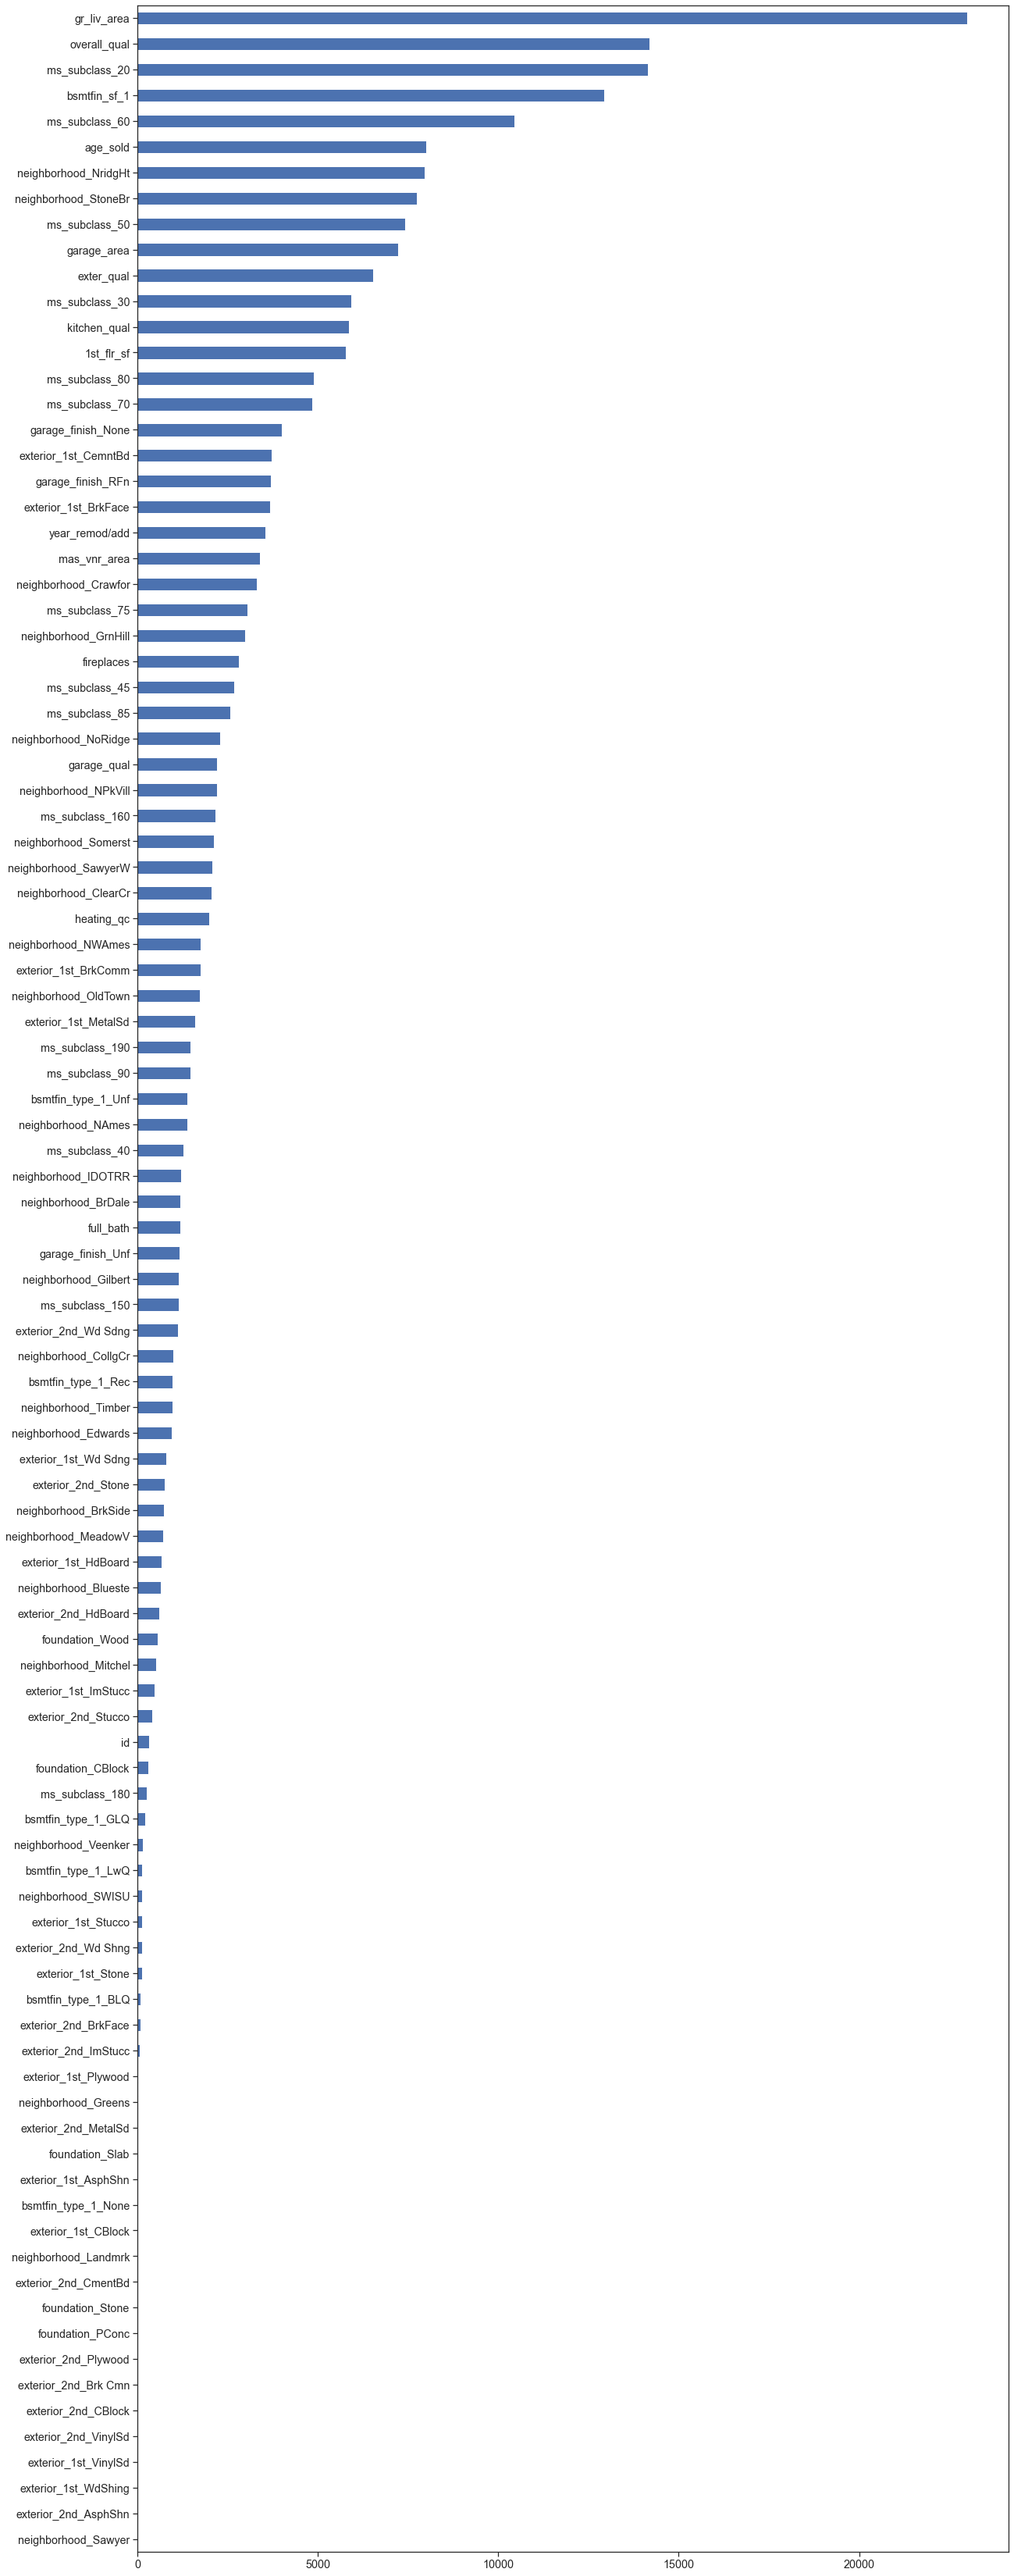

In [32]:
pd.Series(lasso.coef_, index=num_features).abs().sort_values(ascending=True).plot.barh(figsize=(20,60))

>**Interpretation**
> - The magnitude of the lasso coefficients shows the impact of the predictors (X variables) on the response (target: saleprice).   
> - Based on the absolute coefficients, the top 10 predictors on saleprice are as follows: 
>  1. Large ground living area in square feet
>  2. Excellent rating of the overall material and finish of the house
>  3. Excellent rating of the basement finished area
>  4. 'Younger' age of the house
>  6. Houses in Northridge Heights and Stone Brook can fetch higher prices. 
>  7. Large garage area
>  8. Excellent external quality of the house
>  9. Excellent kitchen quality
>  10. Large size of the 1st floor

In [33]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs = lasso_coefs[lasso_coefs['coef'] != 0]

lasso_coefs = lasso_coefs.reindex(lasso_coefs['abs_coef'].sort_values(ascending=False).index).head(20)

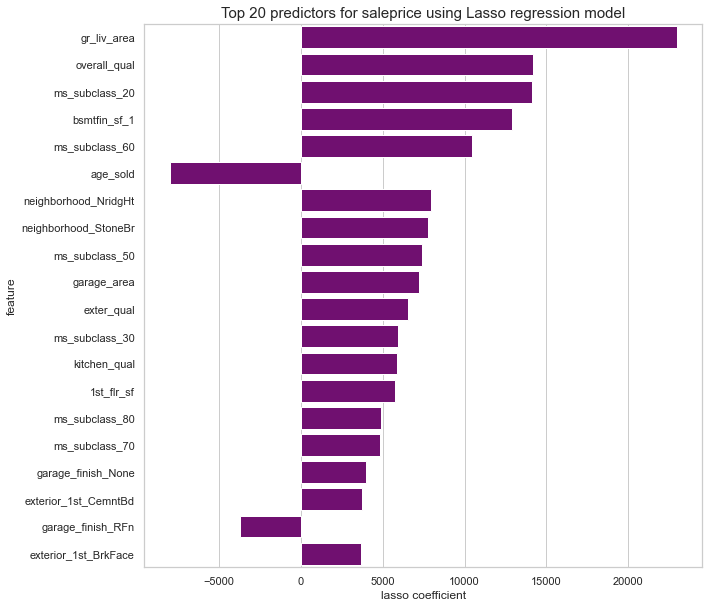

In [34]:
sns.set(style='whitegrid',rc={"figure.figsize":(10, 10)})

sns.barplot(lasso_coefs[lasso_coefs.columns[1]],lasso_coefs[lasso_coefs.columns[0]], orient = 'h',color='purple')
plt.xlabel('lasso coefficient', fontsize=12)
plt.ylabel('feature', fontsize=12)
plt.title('Top 20 predictors for saleprice using Lasso regression model', fontsize=15);

In [35]:
resids = y_val - las_ypreds

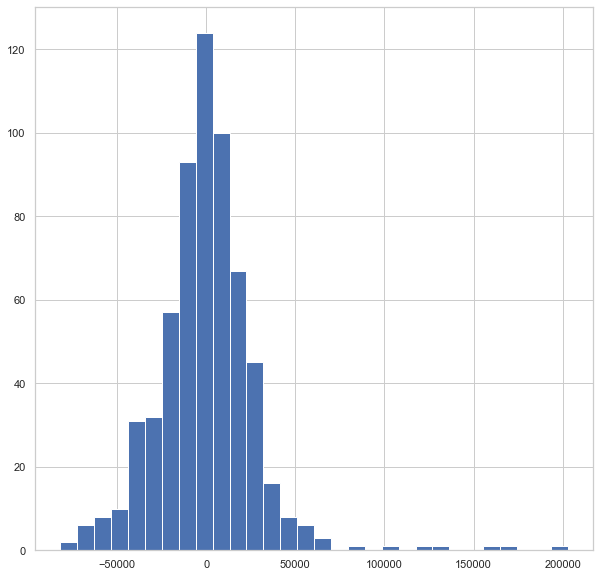

In [36]:
# Distribution of errors

las_resids = y_val - las_ypreds
plt.hist(las_resids,bins=30);

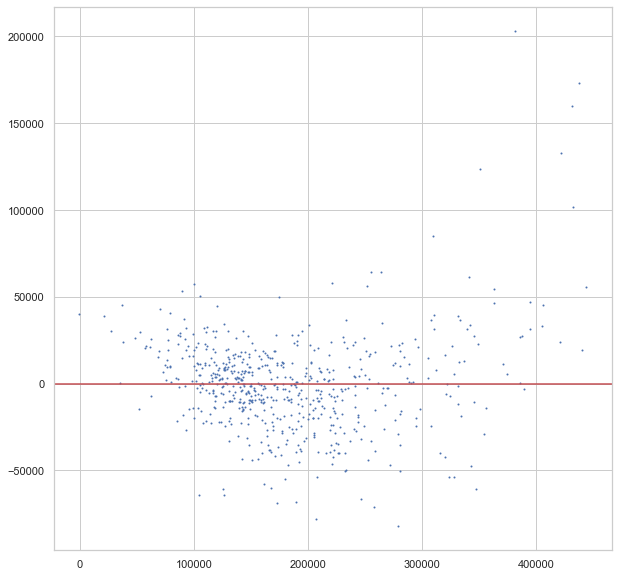

In [37]:
# variance of errors (homosscedasticity)

plt.scatter(las_ypreds, las_resids,s=1)
plt.axhline(0,color='r')

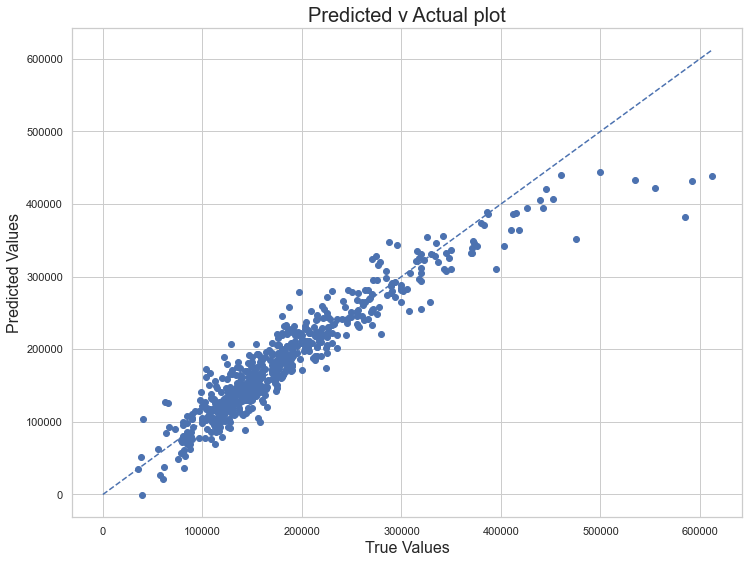

In [38]:
plt.figure(figsize = (12,9))

plt.scatter(y_val,las_ypreds)

plt.plot([0,max(max(y_val),max(las_ypreds))],
        [0,max(max(y_val),max(las_ypreds))],
        linestyle = '--')

plt.title('Predicted v Actual plot', fontsize = 20)
plt.xlabel('True Values', fontsize = 16)
plt.ylabel('Predicted Values', fontsize = 16);

### 2. Linear Regression

In [39]:
# proceed with linear regression 

lr.fit(X_train,y_train)

LinearRegression()

In [40]:
lr_ypreds = lr.predict(X_val)

In [41]:
# linear regression R2 on train-val sets

print(f'Linear - R2 on training set: {r2_score(y_train, lr.predict(X_train))}')
print(f'Linear - R2 on validation set: {r2_score(y_val, lr_ypreds)}')

Linear - R2 on training set: 0.907744646798407
Linear - R2 on validation set: -9.87962650390925e+20


In [42]:
# linear rmse on train-val sets

lr_rmse_train = (mean_squared_error(y_train,lr.predict(X_train),squared=False))
lr_rmse_val = (mean_squared_error(y_val,lr_ypreds,squared=False))
print('Linear - RMSE training set: ',lr_rmse_train)
print('Linear - RMSE validation set: ',lr_rmse_val)

Linear - RMSE training set:  23324.538599053514
Linear - RMSE validation set:  2665014897062426.5


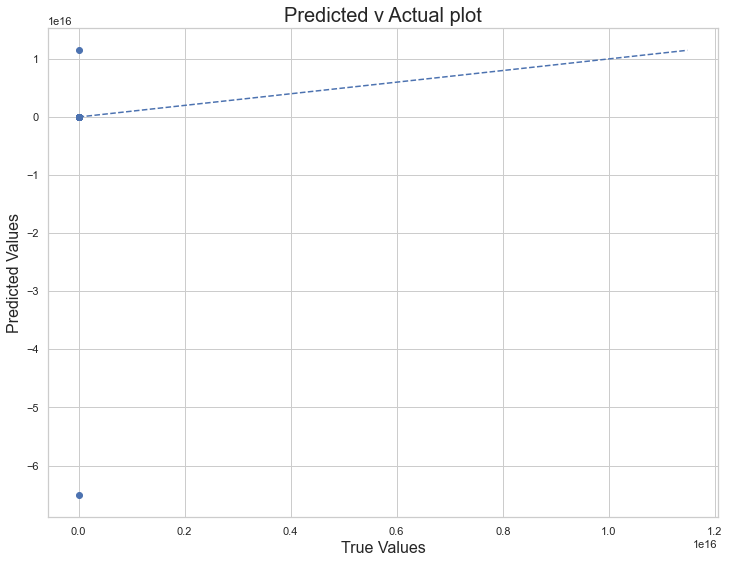

In [43]:
plt.figure(figsize = (12,9))

plt.scatter(y_val,lr_ypreds)

plt.plot([0,max(max(y_val),max(lr_ypreds))],
        [0,max(max(y_val),max(lr_ypreds))],
        linestyle = '--')

plt.title('Predicted v Actual plot', fontsize = 20)
plt.xlabel('True Values', fontsize = 16)
plt.ylabel('Predicted Values', fontsize = 16);

> **Interpretation**
>  - Linear Regression was not able to predict the saleprices well at all! 
>  - The ranges of the values are all over the place. 
>  - This is because linear regression was unable to account for the multicollinearity of features in the dataset.

## 3. Ridge Regression

In [44]:
# ridge

ridge.fit(X_train,y_train)

Ridge(alpha=32.176417502507356)

In [45]:
rd_ypreds = ridge.predict(X_val)

In [46]:
# ridge regression R2 on train-val sets

print(f'Ridge - R2 on training set: {r2_score(y_train, ridge.predict(X_train))}')
print(f'Ridge - R2 on validation set: {r2_score(y_val, rd_ypreds)}')

Ridge - R2 on training set: 0.9065797018071664
Ridge - R2 on validation set: 0.8909002036063282


In [47]:
# ridge rmse on train-val sets

rd_rmse_train = (mean_squared_error(y_train,ridge.predict(X_train),squared=False))
rd_rmse_val = (mean_squared_error(y_val,rd_ypreds,squared=False))
print('Ridge - RMSE training set: ',rd_rmse_train)
print('Ridge - RMSE validation set: ',rd_rmse_val)

Ridge - RMSE training set:  23471.340727695788
Ridge - RMSE validation set:  28005.372125397294


In [48]:
# Ridge regression model - cross-val scores for comarison

rd_r2 = cross_val_score(ridge, X_train, y_train.values.ravel(), cv=5)
rd_rmse = -cross_val_score(ridge, X_train, y_train,cv=5,scoring='neg_root_mean_squared_error')
print('Ridge regression model, R2 score: ',rd_r2.mean())
print('Ridge regression model, RMSE: ',rd_rmse.mean())

Ridge regression model, R2 score:  0.8866448171558747
Ridge regression model, RMSE:  25634.898381096315


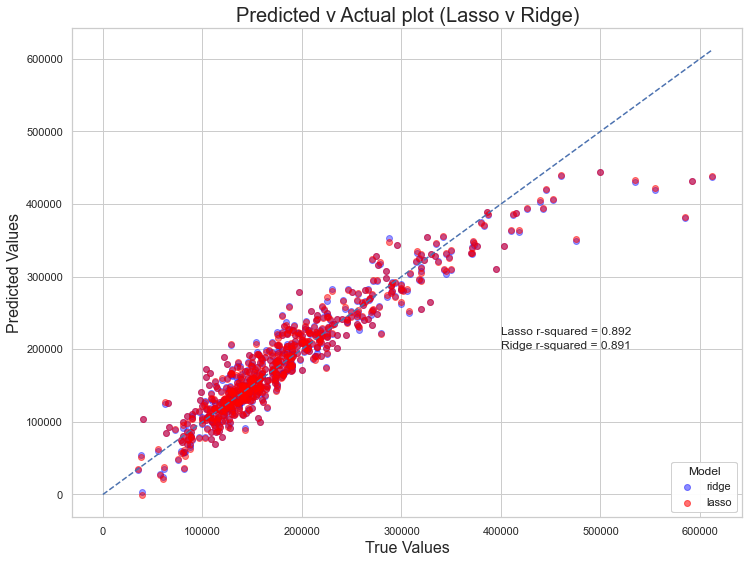

In [49]:
fig, ax = plt.subplots(figsize = (12,9))

classes = ['ridge', 'lasso']

scatter = ax.scatter(y_val,rd_ypreds,color='blue',alpha=0.4)
scatter = ax.scatter(y_val,las_ypreds,color='red',alpha=0.5)

legend1 = ax.legend(*scatter.legend_elements()[0],labels=classes,
                    loc="lower right", title="Model")
ax.add_artist(legend1)

plt.plot([0,max(max(y_val),max(rd_ypreds))],
        [0,max(max(y_val),max(rd_ypreds))],
        linestyle = '--')

plt.annotate("Ridge r-squared = {:.3f}".format(r2_score(y_val, rd_ypreds)), (400000,200000))
plt.annotate("Lasso r-squared = {:.3f}".format(r2_score(y_val, las_ypreds)), (400000,220000))

plt.title('Predicted v Actual plot (Lasso v Ridge)', fontsize = 20)
plt.xlabel('True Values', fontsize = 16)
plt.ylabel('Predicted Values', fontsize = 16);

> **Interpretation**
>  - The plot above shows a comparison of the ridge and lasso regression models. 
>  - As you can see, the data points for both models largely overlap. 
>  - Both models are performing well and consistantely, which suggests that the datasets are stable. 
>  - The r2 scores for both models are also close to each other, with a minute difference of 0.001. 

### Applying lasso regression on test set to predict housing prices 

In [50]:
# note that despite the data cleaning done in previous notebook, the train and test sets do not have the same
# number of columns anymore because we had earlier applied get_dummies which generated more columns for categorical data!

print(train.shape)
print(test.shape)

(2048, 100)
(878, 22)


In [51]:
# create a copy of the test set for model prep

test_c = test.copy()

### Model Prep: One-Hot Encoding

In [52]:
test_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              878 non-null    int64  
 1   ms_subclass     878 non-null    object 
 2   neighborhood    878 non-null    object 
 3   overall_qual    878 non-null    int64  
 4   year_remod/add  878 non-null    int64  
 5   exterior_1st    878 non-null    object 
 6   exterior_2nd    878 non-null    object 
 7   mas_vnr_area    878 non-null    float64
 8   exter_qual      878 non-null    int64  
 9   foundation      878 non-null    object 
 10  bsmtfin_type_1  878 non-null    object 
 11  bsmtfin_sf_1    878 non-null    float64
 12  heating_qc      878 non-null    int64  
 13  1st_flr_sf      878 non-null    int64  
 14  gr_liv_area     878 non-null    int64  
 15  full_bath       878 non-null    int64  
 16  kitchen_qual    878 non-null    int64  
 17  fireplaces      878 non-null    int

In [53]:
test_c = pd.get_dummies(test_c,drop_first=True)

In [54]:
len(test_c.columns)

95

### Model Prep: Ensure consistent columns in train & test sets

In [55]:
# x_features was created earlier to refer to all independent variables in the train set 
# that was used for modelling
# it excludes the target i.e. saleprice

x_features = [x for x in train.columns if x != 'saleprice']
len(x_features)

99

In [56]:
# these are the features that are available in the train set but not in the test set
# other than saleprice (i.e the target), the remaining columns were created in train set because the categories are present in the features 'neighhborhood' and 'exterior'

missing_cols = list(set(train.columns) - set(test_c .columns))
missing_cols

['exterior_1st_ImStucc',
 'exterior_1st_Stone',
 'saleprice',
 'exterior_1st_CBlock',
 'neighborhood_Landmrk',
 'ms_subclass_150',
 'exterior_2nd_Stone',
 'neighborhood_GrnHill']

In [57]:
# introduced a for loop to create those missing_cols in test set and impute w value 0

for c in missing_cols:
    test_c [c] = 0

In [58]:
# to define X_test as including all common features with train set except for target i.e. saleprice

X_test = test_c[all_features]

In [59]:
# now test set has same number of features as train set (except saleprice)

print(X_test.shape)
print(train.shape)

(878, 99)
(2048, 100)


### Model Prep: Scaling

We will transform the X_test set using the same scale fitted using X_train. We do not fit the X_test using the standardScaler because this will create a different set of scale parameters from that of X_train. 

We must ensure that the same set of scale parameters are used on X_train, X_val and X_test. 

In [60]:
X_test = ss.transform(X_test)

### Model Predictions

In [61]:
y_preds =lasso.predict(X_test)

In [62]:
y_preds.shape

(878,)

### Export Predictions

In [63]:
# to impute the 'saleprice' column in test set with the predicted values

test_c['saleprice'] = y_preds

In [64]:
# to create a new dataframe which consists only of the id and saleprice features

final = test_c[['id','saleprice']]

In [65]:
# to verify that the submission file is in the right format

final.tail()

,id,saleprice
873,1662,189553.743132
874,1234,217339.580971
875,1373,138282.704460
876,1672,112643.829028
877,1939,134081.814066


In [66]:
final.to_csv('submission_v5',index=False)

In [67]:
# Kaggle submission and results below

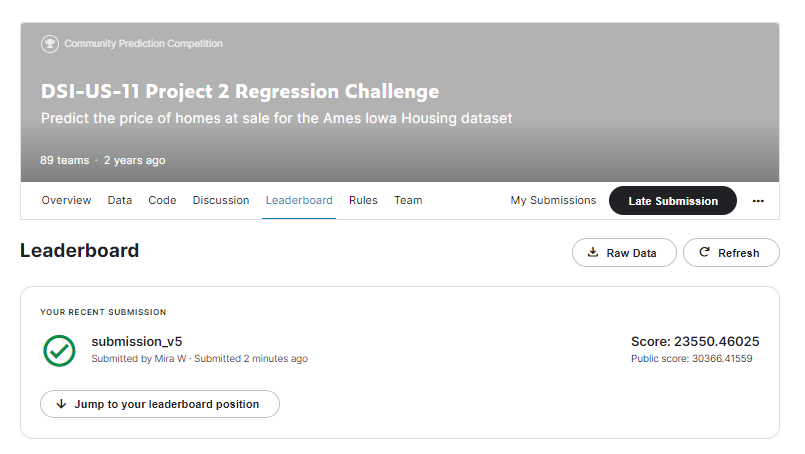